# Chronos Vignette

This vignette walks through a simple exercise in training Chronos on a subset of DepMap public 20Q4 and the Sanger Institute's Project Score data. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import chronos
import os
from matplotlib import pyplot as plt
import seaborn as sns
from taigapy import default_tc as tc

Some tweaks that will make plots more legible

In [3]:
from matplotlib import rcParams
rcParams['axes.titlesize'] = 14
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['savefig.dpi'] = 200
rcParams['savefig.transparent'] = False
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = '11'
rcParams['figure.dpi'] = 200
rcParams["savefig.facecolor"] = (1, 1, 1.0, 0.2)

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 7

## Setting up the Data

Chronos always requires at least three dataframes: 
* a matrix of readcounts with sequenced entities as the index, individual sgRNAs as the columns, and values indicating how many reads were found for that sgRNA. A sequenced entity any vector of sgRNA readcounts read out during the experiment. It could be a sequencing run of pDNA, or of a biological replicate at some time point during the experiment.
* A sequence map mapping sequenced entities to either pDNA or a cell line and giving the days since infection and pDNA batch. 
* A guide map mapping sgRNAs to genes. Each sgRNA included must map to one and only one gene.

Below, we'll load a small subset of the DepMap Avana data. The files have been reformatted from the release to the format Chronos expects

In [4]:
import h5py
h5py

<module 'h5py' from '/opt/homebrew/lib/python3.11/site-packages/h5py/__init__.py'>

In [5]:
sequence_map = pd.read_csv("Data/SampleData/AvanaSequenceMap.csv")
guide_map = pd.read_csv("Data/SampleData/AvanaGuideMap.csv")
readcounts = chronos.read_hdf5("Data/SampleData/AvanaReadcounts.hdf5")

Sequence maps must have the columns

* sequence_id (str), which must match a row in readcounts
* cell_line_name (str). Must be "pDNA" for pDNA, and each pDNA batch must have at least one pDNA measurement.
* pDNA batch (any simple hashable type, preferably int or str). pDNA measurements sharing the same batch will be grouped and averaged, then used as the reference for all biological replicate sequencings assigned that same batch. If you don't have multiple pDNA batches (by far the most common experimental condition), just fill this column with 0 or some other constant value.
* days: days post infection. This value will be ignored for pDNA.

Other columns will be ignored.

In [6]:
sequence_map[:5]

,sequence_ID,ScreenID,days,pDNA_batch,Replicate,ScreenType,cell_line_name,ModelConditionID,Library,PassesQC
0,HEL-311Cas9_RepA_p4_Avana-3,SC-000004.AV01,21,Avana-3,A,2DS,ACH-000004,MC-000004-pA3k,Avana,True
1,HEL-311Cas9_RepB_p4_Avana-3,SC-000004.AV01,21,Avana-3,B,2DS,ACH-000004,MC-000004-pA3k,Avana,True
2,KU812-311cas9-RepA-p6_Avana-3,SC-000074.AV01,21,Avana-3,A,2DS,ACH-000074,MC-000074-OKtM,Avana,True
3,KU812-311cas9-RepB-p6_Avana-3,SC-000074.AV01,21,Avana-3,B,2DS,ACH-000074,MC-000074-OKtM,Avana,True
4,T47D-311Cas9-RepA-p6_Avana-4,SC-000147.AV01,21,Avana-4,A,2DS,ACH-000147,MC-000147-Uovr,Avana,True


Guide maps must have the columns 

* sgrna (str): must match a column in readcounts. An sgrna can only appear once in this data frame.
* gene (str): the gene the sgrna maps to.

Other columns will be ignored.

In [7]:
guide_map[:4]

,sgrna,GenomeAlignment,gene,nAlignments,DropReason,UsedByChronos
0,AAAAATGCGCAAATTCAGCG,chr3_138742712_-,PIK3CB (5291),1.0,NaN,True
1,AAAACACATCAGTATAACAT,chr3_49368469_+,RHOA (387),1.0,NaN,True
2,AAAACTACAGAAGCCTCCCG,chr10_34450424_-,PARD3 (56288),1.0,NaN,True
3,AAAAGGCCTGACATATCTGA,chr15_66444677_+,MAP2K1 (5604),2.0,NaN,True


Finally, here's what readcounts should look like. They can include NaNs. Note the axes.

In [8]:
readcounts.iloc[:4, :3]

,AAAAATGCGCAAATTCAGCG,AAAACACATCAGTATAACAT,AAAACTACAGAAGCCTCCCG
HEL-311Cas9_RepA_p4_Avana-3,101.0,224.0,636.0
HEL-311Cas9_RepB_p4_Avana-3,147.0,400.0,350.0
KU812-311cas9-RepA-p6_Avana-3,124.0,191.0,364.0
KU812-311cas9-RepB-p6_Avana-3,129.0,536.0,1280.0


To QC the data, we'll want control groups. We'll use predefined sets of common and nonessential genes, and use these to define control sets of sgRNAs.

In [9]:
common_essentials = pd.read_csv("Data/SampleData/AchillesCommonEssentialControls.csv")["Gene"]
nonessentials = pd.read_csv("Data/SampleData/AchillesNonessentialControls.csv")["Gene"]

In [10]:
positive_controls = guide_map.sgrna[guide_map.gene.isin(common_essentials)]
negative_controls = guide_map.sgrna[guide_map.gene.isin(nonessentials)]

### NaNing clonal outgrowths

In Achilles, we've observed rare instances where a single guide in a single biological replicate will produce an unexpectedly large number of readcounts, while other guides targeting the same gene or other replicates of the same cell line do not show many readcounts. We suspect this is the result of a single clone gaining some fitness advantage. Although it _could_ be related to a change induced by the guide, in general it's probably misleading. Therefore Chronos has an option to identify and remove these events.

In [11]:
chronos.nan_outgrowths(readcounts=readcounts, guide_gene_map=guide_map,
                                   sequence_map=sequence_map)

calculating LFC
stacking and annotating LFC


/Users/dempster/packages/chronos_public/chronos/model.py:215: RuntimeWarning: divide by zero encountered in divide
  fc = pd.DataFrame(fc.values/pdna_reference.loc[sequence_map.set_index('sequence_ID').loc[reps, 'pDNA_batch']].values,
/Users/dempster/packages/chronos_public/chronos/model.py:215: RuntimeWarning: invalid value encountered in divide
  fc = pd.DataFrame(fc.values/pdna_reference.loc[sequence_map.set_index('sequence_ID').loc[reps, 'pDNA_batch']].values,
/Users/dempster/packages/chronos_public/chronos/model.py:439: RuntimeWarning: divide by zero encountered in log2
  np.log2(fc.values), index=fc.index,columns=fc.columns


finding group boundaries
removing cases with only one guide and replicate
finding maximal values
making mask
found 7 outgrowths, 2.2E-05 of the total
pivoting mask
aligning_mask
NaNing


/Users/dempster/packages/chronos_public/chronos/model.py:478: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lfc_stack["Mask"].loc[bad_rows] = True
/Users/dempster/packages/chronos_public/chronos/model.py:478: SettingWithCopyWarning: 
A value

### QCing the data

You can generate a report with basic QC metrics about your data. You don't have to have control guides to do this, but the report is most useful if you do. If you don't have the `reportlab` python package installed, this section will error and should be skipped. This command will write a pdf report named "Initial QC.pdf" in the `./Data/reports` directory.

In [12]:
reportdir = "./Data/reports"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/reports"
! mkdir "./Data/reports"

In [13]:
from chronos import reports
metrics = reports.qc_initial_data("Initial QC", readcounts, sequence_map,guide_map, 
        negative_controls, positive_controls,
                  directory=reportdir
       )

/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

calculating replicate correlation
generating control separation metrics
Plotting log fold-change distribution


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


plotting control separation metrics


/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/evaluations.py:317: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/

Look in the Data/reports directory to see the QC report, "Initial QC.pdf".

## Train Chronos

### Creating the model

Now we initialize the model. Note the form of the data: each of the three parameters is actually a dictionary. If we were training the model with data from multiple libraries simultaneously, each library's data would have its own entries in the dict. 

The `negative_control_sgrnas` is an optional parameter, but including it will allow 1. better removal of library size effects from readcounts, and 2. estimation of the negative binomial quadratic overdispersion parameter per screen, which is otherwise a fixed hyperparameter. If provided, these should be cutting sgRNAs that are strongly expected to have no viability impact.

`log_dir` is an optional argument containing a directory for tensorflow to write summaries to. We include it here so that tensorboard can load the model.

In [14]:
logdir = "./Data/logs"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/logs"
! mkdir "./Data/logs"

In [130]:
import warnings
warnings.filterwarnings("error")

In [131]:
model = chronos.Chronos(
    sequence_map={"avana": sequence_map},
    guide_gene_map={"avana": guide_map},
    readcounts={"avana": readcounts},
    negative_control_sgrnas={"avana": negative_controls},
    log_dir=logdir
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 92 unique late time points and 44 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [92, 1] for avana

building late observed timepoints
	built normalized timepoints for avana with shape (92, 3474) (replicates X g

2024-08-12 15:16:24.988485: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_28/avana/Assign' id:92918 op device:{requested: '', assigned: ''} def:{{{node excess_variance_28/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_28/avana, excess_variance_28/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
	creating log at ./Data/logs
initializing rest of graph


2024-08-12 15:16:30.237591: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_27/library_effect/avana/Assign' id:93032 op device:{requested: '', assigned: ''} def:{{{node GE_27/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_27/library_effect/avana, GE_27/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 avana
	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
ready to train


If you have tensorboard, the cell below will show Chronos' node structure. `GE` means gene effect (relative change in growth rate), `FC` means predicted fold change, `t0` is the inferred relative guide abundance at t0, and `out_norm` is the predicted readcounts. 

In [16]:
%reload_ext tensorboard
!kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
%tensorboard --logdir ./data/logs

Now, optimizing the model:

### Train

Below, we train  the model for 301 epochs. This should take a minute or so with periodic updates provided

In [132]:
model.train(301)

NB2 cost 0.8058704672804937
Full cost 0.8953799625512898
relative_growth_rate
	avana max 1.057, min 0.95814
mean guide efficacy 0.9991814135764885
t0_offset SD: [('avana', 7.071637591842546e-05)]

gene mean -0.2067779237845317
SD of gene means 0.2994857735474827
Mean of gene SDs 0.2673650109993013



51 epochs trained, time taken 0:00:03, projected remaining 0:00:16
NB2 cost 0.31534656167265745
Full cost 0.3774814419956902
relative_growth_rate
	avana max 1.121, min 0.38272
mean guide efficacy 0.9026981068463629
t0_offset SD: [('avana', 0.14155660164208933)]

gene mean -0.1318506595353203
SD of gene means 0.33112118502988247
Mean of gene SDs 0.23993253708615703



101 epochs trained, time taken 0:00:05, projected remaining 0:00:09
NB2 cost 0.2448701780390689
Full cost 0.2762748644552632
relative_growth_rate
	avana max 1.707, min 0.17346
mean guide efficacy 0.874520048481221
t0_offset SD: [('avana', 0.14155049799959127)]

gene mean 0.0013798109275200122
SD of gene means 0.416794138494428

In [133]:
presummed = model.cost_presum['avana']

In [139]:
ev = model.excess_variance['avana'].values.reshape((-1, 1))

In [140]:
reads = model.normalized_readcounts['avana'].values

In [141]:
preds = model.predicted_readcounts['avana'].values

In [142]:
manual_presummed = pd.DataFrame(
    ((reads+1e-6) + 1./ev) * np.log(
        1 + ev * (preds + 1e-6)
) -
    (reads+1e-6) * np.log(
        (ev * preds + 1e-6)
    ),
    index=presummed.index, columns = presummed.columns
)

In [ ]:
presummed -

## After Training

### Saving and Restoring

Chronos' `save` method dumps all the inputs, outputs, and model parameters to the specified directory. These files are written such that they can be read in individually and analyzed, but also used to restore the model by passing the directory path to the function `load_saved_model`.

In [18]:
savedir = "Data/Achilles_run_compare"

In [19]:
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [39]:
model.save(savedir, overwrite=True)

2024-08-12 11:49:46.131003: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_12/library_effect/avana/Adam_1/Assign' id:36917 op device:{requested: '', assigned: ''} def:{{{node GE_12/library_effect/avana/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_12/library_effect/avana/Adam_1, GE_12/library_effect/avana/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [40]:
print("Saved files:\n\n" + '\n'.join(['\t' + s for s in os.listdir(savedir)
                if s.endswith("csv")
                or s.endswith("hdf5")
                or s.endswith("json")
                ]))

Saved files:

	library_effect.csv
	cell_line_growth_rate.csv
	replicate_growth_rate.csv
	avana_predicted_readcounts.hdf5
	growth_rate.csv
	parameters.json
	guide_efficacy.csv
	avana_sequence_map.csv
	replicate_efficacy.csv
	t0_offset.csv
	avana_predicted_lfc.hdf5
	avana_guide_gene_map.csv
	gene_effect_corrected.hdf5
	avana_negative_control_sgrnas.csv
	screen_delay.csv
	screen_excess_variance.csv
	cell_line_efficacy.csv
	gene_effect.hdf5
	avana_readcounts.hdf5


The .hdf5 files are binaries written with chronos' `write_hdf5` function, which is an efficient method for writing large matrices. They can be read with chronos' `read_hdf5` function.

Restoring the model can be done with a single function call:

In [41]:
model_restored = chronos.load_saved_model(savedir)



Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 92 unique late time points and 44 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [92, 1] for avana

building late observed timepoints


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) and 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (3, 3474) for avana
building guide efficacy
built guide efficacy: shape [1, 3475]
building growth rate
built growth rate: shape {'avana': [92, 1]}

building replicate efficacy
built replicate efficacy: shapes {'avana': [92, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 44 cell lines by 883 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 883]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [92, 883]}

building combined efficacy
built combined efficacy, shape {'avana': [92, 3474]}
built expanded combined efficacy, shapes {'avana': [92, 3474]}

building growth estimates of edited cells and overall estimates of fold change in guide abundance
built growth and change


2024-08-12 11:49:47.805040: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_14/avana/Assign' id:41340 op device:{requested: '', assigned: ''} def:{{{node excess_variance_14/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_14/avana, excess_variance_14/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph


2024-08-12 11:49:49.210599: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_14/library_effect/avana/Assign' id:41454 op device:{requested: '', assigned: ''} def:{{{node GE_14/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_14/library_effect/avana, GE_14/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
ready to train
assigning trained parameters
	library effect
	gene effect
	guide efficacy
	cell efficacy
                                                   library  replicate_efficacy
replicate_ID                                                                  
ACH-000004_Avana-3_HEL-311Cas9_RepA_p4_Avana-3       avana            0.848895
ACH-000004_Avana-3_HEL-311Cas9_RepB_p4_Avana-3       avana            0.839082
ACH-000074_Avana-3_KU812-311cas9-RepA-p6_Avana-3     avana            0.800177
ACH-000074_Avana-3_KU812-311cas9-RepB-p6_Avana-3     avana            0.737671
ACH-000147_Avana-4_T47D-311Cas9-RepA-p6_Avana-4      avana            0.900404
...                                       

In [42]:
print("trained model cost: %f\nrestored model cost: %f" % (model.cost, model_restored.cost))

2024-08-12 11:50:20.006410: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_13/library_effect/avana/Adam_1/Assign' id:39866 op device:{requested: '', assigned: ''} def:{{{node GE_13/library_effect/avana/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_13/library_effect/avana/Adam_1, GE_13/library_effect/avana/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


trained model cost: 0.232813
restored model cost: 0.232816


The most important file for most use cases is gene_effect.hdf5, which holds Chronos' estimate of the relative change in growth rate caused by gene knockouts. Negative values indicate inhibitory effects. You can also access the gene effect (and other parameters) from the trained model directly:

In [43]:
gene_effects = model.gene_effect

gene_effects.iloc[:4, :5]

gene,A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947)
cell_line_name,,,,,
ACH-000004,0.394541,0.097681,0.326139,0.489147,0.255511
ACH-000074,0.460853,0.558831,0.754762,0.420351,0.382964
ACH-000147,0.435761,0.398605,0.530612,0.213187,0.516680
ACH-000168,0.422915,0.457571,0.628621,0.339600,0.343899


If your library includes many depleting genes with negative gene effect scores, this can drive nonessential genes towards positive values as Chronos tries to maintain the overall mean score near 0: 

In [44]:
print("Mean of all effects: %1.3f, mean of nonessential gene effects: %1.3f" %(
    np.nanmean(gene_effects.mean()), np.nanmean(gene_effects.reindex(columns=nonessentials))
))

Mean of all effects: 0.003, mean of nonessential gene effects: 0.372


We usually want nonessential gene effects to be centered at 0, so we can interpret 0 gene effect as "no impact on viability." This is a trivial change to make.

In [45]:
gene_effects -= np.nanmean(gene_effects.reindex(columns=nonessentials))

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Distribution of adjusted gene effects')

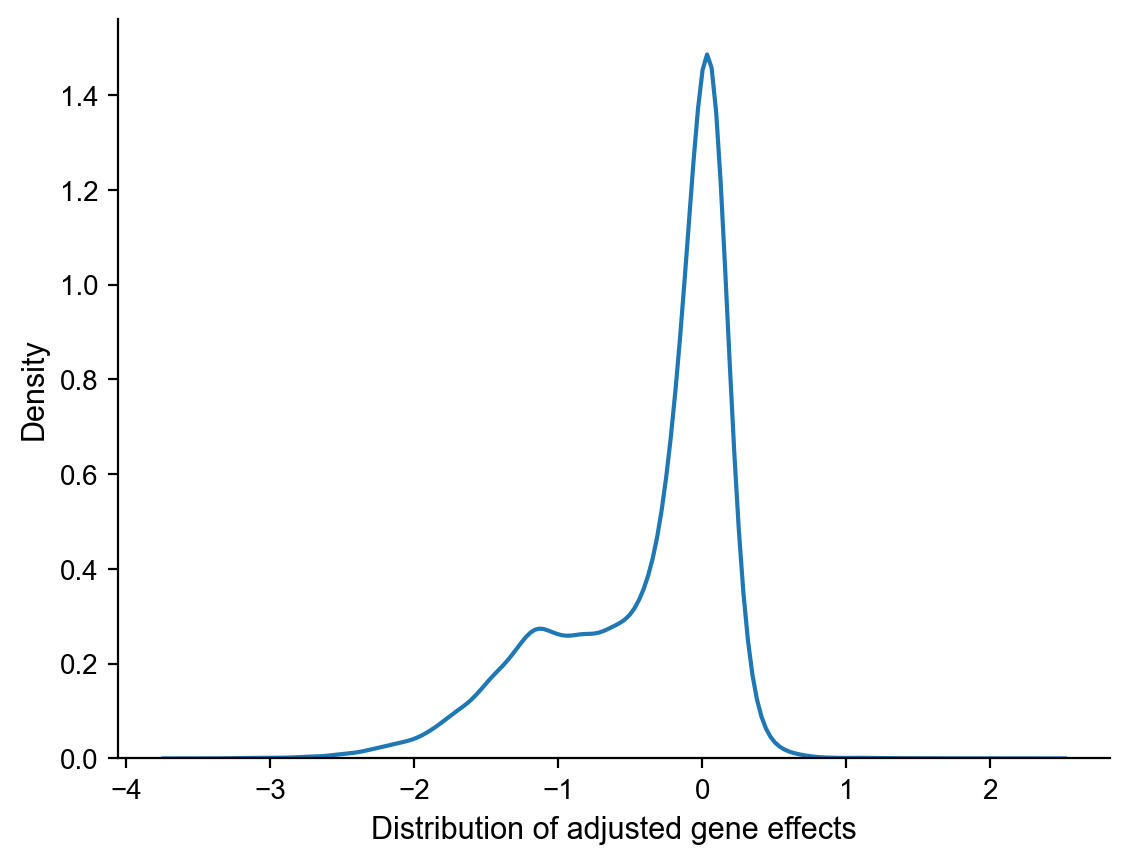

In [46]:
sns.kdeplot(np.ravel(gene_effects))
plt.xlabel("Distribution of adjusted gene effects")

### Copy Number Correction

If you have gene-level copy number calls, Chronos includes an option to correct gene effect scores after the fact. This works best if the data has been scaled, as above.

In [49]:
cn = chronos.read_hdf5("Data/SampleData/OmicsCNGene.hdf5")
cn.iloc[:4, :3]

,A1CF (29974),A2M (2),A2ML1 (144568)
ACH-001636,1.110663,1.047670,1.047670
ACH-000784,1.193826,1.161938,1.109943
ACH-000147,1.365585,0.499068,0.499068
ACH-000657,1.033547,1.040547,1.040547


Unfortunately, we don't have copy number calls for one of the genes targeted by the Avana library:

In [50]:
try:
    corrected, shifts = chronos.alternate_CN(gene_effects, cn)
except ValueError as e:
    print(e)

Missing 1 genes from gene_effect in copy_number.
Examples: ['POU2AF3 (120376)']


We could choose to drop these genes. Instead, we'll assume normal ploidy (=1, in the current CCLE convention) for them and fill in the CN matrix accordingly.

In [51]:
for col in set(gene_effects.columns) - set(cn.columns):
    cn[col] = 1

In [52]:
corrected, shifts = chronos.alternate_CN(gene_effects, cn)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 38852, 105
	cost: 0.05977376112281391
	cost: 0.05909455735833785
	cost: 0.05903950275919463
	cost: 0.05900787423587113
	cost: 0.058986548214719846
	cost: 0.05897106509489016
generating matrix


The `shifts` dataframe contains some information about the inferred CN effect, while `corrected` contains the corrected gene effects matrix. Overall, gene effect matrices will change little after correction, since most genes in most lines are near diploid.

We'll write the corrected dataframe to the saved directory we made earlier

In [53]:
chronos.write_hdf5(corrected, os.path.join(savedir, "gene_effect_corrected.hdf5"))

### QC report

The function `dataset_qc_report` in the `reports` module of Chronos presents a variety of QC metrics and interrogates some specific examples. The report minimally requires a set of positive and negative control genes. To get the full report requires copy number, mutation data, expression data, a list of expression addictions (genes which are dependencies in highly expressing lines), and oncogenic mutations.

Below, we'll load an annotated DepMap MAF file (subsetted to our cell lines). We'll select gain of function cancer driver events from it and generate a binary mutation matrix. We have a prior belief that cell lines with driver gain of function mutation events will be dependent on the mutated gene, so this matrix will be used by the QC report to assess our ability to identify selective dependencies. Specifically, we expect the oncogenes in this matrix to be dependencies in cell lines where the matrix is `True`, and not otherwise.

In [54]:
maf = pd.read_csv("Data/SampleData/OmicsSomaticMutations.csv")

In [55]:
cancer_relevant = maf[
  (
      maf.Driver | maf.LikelyDriver  
  ) & (
      maf.LikelyGoF
  )
]


cancer_relevant = cancer_relevant[~cancer_relevant.duplicated(subset=["ModelID", "Gene"])]

cancer_relevant['truecol'] = True

gof_matrix_base = pd.pivot(cancer_relevant, index="ModelID", columns="Gene", values="truecol")

Another way to evaluate selective dependencies is using expression addictions, a common pattern in which a gene is a stronger dependency in lines with higher expression. We'll use a list derived from DepMap RNAi (Tsherniak et al., Cell 2017), and subset our expression matrix to match.

In [56]:
expression_addictions = pd.read_csv("Data/SampleData/RNAiExpressionAddictions.csv")['Gene']

In [57]:
addiction_expressions = chronos.read_hdf5("Data/SampleData/OmicsExpressionProteinCodingGenesTPMLogp1.hdf5")[
    expression_addictions
]

Now, we're ready to run the QC report on Chronos' results:

In [58]:
metrics = reports.dataset_qc_report("ChronosAvana", savedir, 
                          common_essentials, nonessentials,
                          gof_matrix_base, addiction_expressions,
                          cn, directory="Data/reports",
                          gene_effect_file="gene_effect_corrected.hdf5"
                         )

Loading data from Data/Achilles_run_compare
plotting global control separation


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

plotting selective dependency separation


/Users/dempster/packages/chronos_public/chronos/evaluations.py:125: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned_matrix = base_matrix.reindex(gene_effect.index).fillna(False)
/Users/dempster/packages/chronos_public/chronos/evaluations.py:761: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(s=neg_means.index[i],x=neg_means[i], y=pos_means[i], fontsize=6, color=[.8, .3, .05]) for i in outliers]


plotting gene effect mean relationships
plotting copy number effect
plotting screen efficacy and growth rate


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


plotting readcount predictions


/Users/dempster/packages/chronos_public/chronos/reports.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


plotting LFC predictions


/Users/dempster/packages/chronos_public/chronos/reports.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/dempster/packages/chronos_public/chronos/reports.py:103: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(data['guide_map'][library].set_index("sgrna").gene, axis=1)\


plotting difference from naive gene score
summarizing
plotting genes with low agreement with naive gene effect
	JAK2 (3717)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK2 (3717), ACH-000004:
avana    av
dtype: object
ATAATCATACCTGAGCAAAG    avGuide1
ATCTGCCTCAGATTTCCCAA    avGuide2
CTGCCACTGCAATACCAACG    avGuide3
GAGGTGCTACTTCTTTACAG    avGuide4
dtype: object
HEL-311Cas9_RepA_p4_Avana-3    avRep1
HEL-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for JAK2 (3717), ACH-001736:
avana    av
dtype: object
ATAATCATACCTGAGCAAAG    avGuide1
ATCTGCCTCAGATTTCCCAA    avGuide2
CTGCCACTGCAATACCAACG    avGuide3
GAGGTGCTACTTCTTTACAG    avGuide4
dtype: object
HB11;19-311CAS9_RepA_p6_Avana-3    avRep1
HB11;19-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
	ESR1 (2099)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for ESR1 (2099), ACH-000147:
avana    av
dtype: object
CGCCGTGTACAACTACCCCG    avGuide1
GCACCATTGATAAAAACAGG    avGuide2
GTAGACCTGCGCGTTGGCGG    avGuide3
TCGCCTTTCCTGCAGCCCCA    avGuide4
dtype: object
T47D-311Cas9-RepA-p6_Avana-4    avRep1
T47D-311Cas9-RepB-p6_Avana-4    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for ESR1 (2099), ACH-001303:
avana    av
dtype: object
CGCCGTGTACAACTACCCCG    avGuide1
GCACCATTGATAAAAACAGG    avGuide2
GTAGACCTGCGCGTTGGCGG    avGuide3
TCGCCTTTCCTGCAGCCCCA    avGuide4
dtype: object
NB1643-311Cas9_RepA_p4_Avana-3    avRep1
NB1643-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
	DPRX (503834)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for DPRX (503834), ACH-000004:
avana    av
dtype: object
AGGACCAGATGCATTCACAC    avGuide1
CCACAACCGCCAATACCAGA    avGuide2
GGCTCAGAGGATCTTCGTAA    avGuide3
TTAGAAGATGCCAGGCTCAG    avGuide4
dtype: object
HEL-311Cas9_RepA_p4_Avana-3    avRep1
HEL-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for DPRX (503834), ACH-001843:
avana    av
dtype: object
AGGACCAGATGCATTCACAC    avGuide1
CCACAACCGCCAATACCAGA    avGuide2
GGCTCAGAGGATCTTCGTAA    avGuide3
TTAGAAGATGCCAGGCTCAG    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	MCM6 (4175)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MCM6 (4175), ACH-000912:
avana    av
dtype: object
GGCAATGATGAAGTAAAACG    avGuide1
GTTCACCCAGAGCTTGTGAG    avGuide2
TCAAGGCCCGACACAGGTAA    avGuide3
TGTTGCGCCAACCAACCCAA    avGuide4
dtype: object
NCI-H2286-311caa9_RepA_p6_Avana-3    avRep1
NCI-H2286-311caa9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MCM6 (4175), ACH-001303:
avana    av
dtype: object
GGCAATGATGAAGTAAAACG    avGuide1
GTTCACCCAGAGCTTGTGAG    avGuide2
TCAAGGCCCGACACAGGTAA    avGuide3
TGTTGCGCCAACCAACCCAA    avGuide4
dtype: object
NB1643-311Cas9_RepA_p4_Avana-3    avRep1
NB1643-311Cas9_RepB_p4_Avana-3    avRep2
dtype: object
	SLC6A5 (9152)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for SLC6A5 (9152), ACH-000657:
avana    av
dtype: object
GGGATGAGAATAAGGCCCGA    avGuide1
GGGTTGTTGCAGGAGCCCCA    avGuide2
TTTGTGTCTGTACTACCCTG    avGuide3
dtype: object
A2780-311cas9 Rep A p6_Avana-2    avRep1
A2780-311cas9 Rep B p6_Avana-2    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for SLC6A5 (9152), ACH-000404:
avana    av
dtype: object
GGGATGAGAATAAGGCCCGA    avGuide1
GGGTTGTTGCAGGAGCCCCA    avGuide2
TTTGTGTCTGTACTACCCTG    avGuide3
dtype: object
K029AX-311cas9_RepB_p6_Avana-3    avRep1
dtype: object
	MED20 (9477)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MED20 (9477), ACH-001842:
avana    av
dtype: object
GCAAGGGCCATTCTCAAAGA    avGuide1
GGACTGTGAGACTTACCATA    avGuide2
TCACTGACCTTGGCTGCCAA    avGuide3
TGGTGTCAGCAATAAGGCAA    avGuide4
dtype: object
ICC2-311cas9_RepA_p6_Avana-3    avRep1
ICC2-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for MED20 (9477), ACH-001563:
avana    av
dtype: object
GCAAGGGCCATTCTCAAAGA    avGuide1
GGACTGTGAGACTTACCATA    avGuide2
TCACTGACCTTGGCTGCCAA    avGuide3
TGGTGTCAGCAATAAGGCAA    avGuide4
dtype: object
MM127-311cas9_RepA_p5_Avana-3    avRep1
MM127-311cas9_RepB_p5_Avana-3    avRep2
dtype: object
	BTK (695)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for BTK (695), ACH-001554:
avana    av
dtype: object
AATGATCTACAGCTGCGGAA    avGuide1
ATAGTAGGAGAGTTTGTGCA    avGuide2
CTGTGTTTGCTAAATCCACA    avGuide3
GATGCTCTCCAGAATCACTG    avGuide4
dtype: object
MEL202-311cas9_RepA_p6_Avana-3    avRep1
MEL202-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for BTK (695), ACH-000183:
avana    av
dtype: object
AATGATCTACAGCTGCGGAA    avGuide1
ATAGTAGGAGAGTTTGTGCA    avGuide2
CTGTGTTTGCTAAATCCACA    avGuide3
GATGCTCTCCAGAATCACTG    avGuide4
dtype: object
L363-311Cas9_RepA_p6_Avana-3    avRep1
L363-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
	OR5M1 (390168)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for OR5M1 (390168), ACH-001533:
avana    av
dtype: object
GTAAAACTCAGTGATCACCA    avGuide1
GTGTGATTAGGTAGATCGCA    avGuide2
TCCTGGAACTGTAATGCAAA    avGuide3
dtype: object
KARPAS1718-311cas9-RepA-p6_Avana-4    avRep1
KARPAS1718-311cas9-RepB-p6_Avana-4    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for OR5M1 (390168), ACH-001843:
avana    av
dtype: object
GTAAAACTCAGTGATCACCA    avGuide1
GTGTGATTAGGTAGATCGCA    avGuide2
TCCTGGAACTGTAATGCAAA    avGuide3
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	GALNTL5 (168391)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GALNTL5 (168391), ACH-000657:
avana    av
dtype: object
ATAAGAAACAAAAAGAGAGA    avGuide1
GAGCTTCTCATGCTTCAGGT    avGuide2
GGAACACCAGAACATCCCCT    avGuide3
TGACAATGCTGGCAGTCGGG    avGuide4
dtype: object
A2780-311cas9 Rep A p6_Avana-2    avRep1
A2780-311cas9 Rep B p6_Avana-2    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GALNTL5 (168391), ACH-001129:
avana    av
dtype: object
ATAAGAAACAAAAAGAGAGA    avGuide1
GAGCTTCTCATGCTTCAGGT    avGuide2
GGAACACCAGAACATCCCCT    avGuide3
TGACAATGCTGGCAGTCGGG    avGuide4
dtype: object
MONO-MAC1-311cas9_RepA_p6_Avana-3    avRep1
MONO-MAC1-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	GPX6 (257202)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GPX6 (257202), ACH-001843:
avana    av
dtype: object
CCAGGTGGATTGCAACAAAG    avGuide1
GAAAAACAGGACAAGACAGG    avGuide2
GATGTACTCCTCGCCGTTGA    avGuide3
TATGGAGCCCTCACCCTCAA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GPX6 (257202), ACH-000774:
avana    av
dtype: object
CCAGGTGGATTGCAACAAAG    avGuide1
GAAAAACAGGACAAGACAGG    avGuide2
GATGTACTCCTCGCCGTTGA    avGuide3
TATGGAGCCCTCACCCTCAA    avGuide4
dtype: object
RERF-LC-Ad2-311cas9_RepA_p6_Avana-3    avRep1
RERF-LC-Ad2-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	IQCF1 (132141)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for IQCF1 (132141), ACH-001129:
avana    av
dtype: object
AGGAGCAGAGTCAAAGGCAG    avGuide1
GAAGCTCTCTGACAAAGATA    avGuide2
GCTCCTAAGGACAAATGGGT    avGuide3
TCTGGTTGAGACACAGACAG    avGuide4
dtype: object
MONO-MAC1-311cas9_RepA_p6_Avana-3    avRep1
MONO-MAC1-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for IQCF1 (132141), ACH-001843:
avana    av
dtype: object
AGGAGCAGAGTCAAAGGCAG    avGuide1
GAAGCTCTCTGACAAAGATA    avGuide2
GCTCCTAAGGACAAATGGGT    avGuide3
TCTGGTTGAGACACAGACAG    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	NPVF (64111)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NPVF (64111), ACH-000479:
avana    av
dtype: object
ACGTTCCTCCCAAATCTCAA    avGuide1
ACTTGCCATTGAGATTTGGG    avGuide2
CATTTCTAATTATAGCCTAG    avGuide3
TAGCCTAGAGGATACCCAAA    avGuide4
dtype: object
KNS-81-311cas9_RepA_p5_Avana-3    avRep1
KNS-81-311cas9_RepB_p5_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for NPVF (64111), ACH-001843:
avana    av
dtype: object
ACGTTCCTCCCAAATCTCAA    avGuide1
ACTTGCCATTGAGATTTGGG    avGuide2
CATTTCTAATTATAGCCTAG    avGuide3
TAGCCTAGAGGATACCCAAA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	TSR2 (90121)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TSR2 (90121), ACH-000946:
avana    av
dtype: object
ACAGCCAGGAGAAGGCCAAG    avGuide1
CCTGTGTTTACAGATCGCTG    avGuide2
CGTTGGTCAACAGCTCTCCA    avGuide3
TTTCCGGGCTGGGGTCTGCG    avGuide4
dtype: object
HEC265-311Cas9_RepA_p6_Avana-3    avRep1
HEC265-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for TSR2 (90121), ACH-000147:
avana    av
dtype: object
ACAGCCAGGAGAAGGCCAAG    avGuide1
CCTGTGTTTACAGATCGCTG    avGuide2
CGTTGGTCAACAGCTCTCCA    avGuide3
TTTCCGGGCTGGGGTCTGCG    avGuide4
dtype: object
T47D-311Cas9-RepA-p6_Avana-4    avRep1
T47D-311Cas9-RepB-p6_Avana-4    avRep2
dtype: object
	RHBDD1 (84236)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RHBDD1 (84236), ACH-001411:
avana    av
dtype: object
CCATGCAACGGAGATCAAGA    avGuide1
CCTGATATCTGGCCATGCAA    avGuide2
CTAAGGCAGGAGCTATACAG    avGuide3
GTATAGCTCCTGCCTTAGTG    avGuide4
dtype: object
UMUC5-311Cas9_RepA_p6_Avana-3    avRep1
UMUC5-311Cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RHBDD1 (84236), ACH-001843:
avana    av
dtype: object
CCATGCAACGGAGATCAAGA    avGuide1
CCTGATATCTGGCCATGCAA    avGuide2
CTAAGGCAGGAGCTATACAG    avGuide3
GTATAGCTCCTGCCTTAGTG    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	CBLIF (2694)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for CBLIF (2694), ACH-000937:
avana    av
dtype: object
ACTTGTATTCCATTGACCAA    avGuide1
GAATGGATACTTTATCCCCA    avGuide2
GGTGAGGCCGAGCTGCCCAA    avGuide3
GTACATACAGGTCAGAGCCA    avGuide4
dtype: object
PF382-311CAS9_RepA_p6_Avana-3    avRep1
PF382-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for CBLIF (2694), ACH-001843:
avana    av
dtype: object
ACTTGTATTCCATTGACCAA    avGuide1
GAATGGATACTTTATCCCCA    avGuide2
GGTGAGGCCGAGCTGCCCAA    avGuide3
GTACATACAGGTCAGAGCCA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	PRMT5 (10419)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PRMT5 (10419), ACH-000993:
avana    av
dtype: object
ATGAACTCCCTCTTGAAACG    avGuide1
CTAGTCATCCCGGAGAAGCA    avGuide2
GGAGAAAAACCCAAATGCCG    avGuide3
GGTTGCTACTCACGTCACCA    avGuide4
dtype: object
JHUEM7-311Cas9_RepA_p5_Avana-3    avRep1
JHUEM7-311Cas9_RepB_p5_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for PRMT5 (10419), ACH-001843:
avana    av
dtype: object
ATGAACTCCCTCTTGAAACG    avGuide1
CTAGTCATCCCGGAGAAGCA    avGuide2
GGAGAAAAACCCAAATGCCG    avGuide3
GGTTGCTACTCACGTCACCA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	GCG (2641)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GCG (2641), ACH-000396:
avana    av
dtype: object
ACGTTCCCTTCAAGACACAG    avGuide1
AGTGGTTGATGAATACCAAG    avGuide2
TGATCCTGATCAGATGAACG    avGuide3
TTTCTCCTCTGTGTCTTGAA    avGuide4
dtype: object
J82-311Cas9_RepA_p5_Avana-3    avRep1
J82-311Cas9_RepB_p5_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for GCG (2641), ACH-001843:
avana    av
dtype: object
ACGTTCCCTTCAAGACACAG    avGuide1
AGTGGTTGATGAATACCAAG    avGuide2
TGATCCTGATCAGATGAACG    avGuide3
TTTCTCCTCTGTGTCTTGAA    avGuide4
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
	RFT1 (91869)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RFT1 (91869), ACH-001736:
avana    av
dtype: object
CCCCACTGAGACATGCTCTG    avGuide1
GCTTGTGCCAAGACCCAAAA    avGuide2
GGAGGCTATGGGCAGCCAGG    avGuide3
GGTGATTGCAGAGAGCCTGT    avGuide4
dtype: object
HB11;19-311CAS9_RepA_p6_Avana-3    avRep1
HB11;19-311CAS9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for RFT1 (91869), ACH-001674:
avana    av
dtype: object
CCCCACTGAGACATGCTCTG    avGuide1
GCTTGTGCCAAGACCCAAAA    avGuide2
GGAGGCTATGGGCAGCCAGG    avGuide3
GGTGATTGCAGAGAGCCTGT    avGuide4
dtype: object
TGW-311Cas9-RepA-P6_Avana-4    avRep1
TGW-311Cas9-RepB-P6_Avana-4    avRep2
dtype: object
	IFNA4 (3441)


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for IFNA4 (3441), ACH-000774:
avana    av
dtype: object
ACATGATTTCGGATTCCCCG    avGuide1
GGCCATCAAACTCCTCCTCG    avGuide2
GTGGCCATCAAACTCCTCCT    avGuide3
dtype: object
RERF-LC-Ad2-311cas9_RepA_p6_Avana-3    avRep1
RERF-LC-Ad2-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
avana    avana
dtype: object avana    avana
dtype: object
Guide and replicate key for IFNA4 (3441), ACH-001843:
avana    av
dtype: object
ACATGATTTCGGATTCCCCG    avGuide1
GGCCATCAAACTCCTCCTCG    avGuide2
GTGGCCATCAAACTCCTCCT    avGuide3
dtype: object
ICC3-311cas9_RepA_p6_Avana-3    avRep1
ICC3-311cas9_RepB_p6_Avana-3    avRep2
dtype: object
building report


## Identifying Hits

You may be interested in getting a list of genes that are true dependencies in your screen. Chronos provides two methods to do this:

- Given a set of negative control genes (or a boolean matrix of individual genes within specific cell lines that are negative controls, such as a matrix of unexpressed genes), Chronos can compute empirical p-values for the null hypothesis that the KO had no viability effect against the alternative hypothesis that it caused loss of viability
-  Given a set of positive and negative control genes, Chronos can estimate the probability that a given gene effect score came from the distribution of positive controls vs negative controls. If the controls are representative of essential/nonessential genes, then the probability tells you how likely it is that a given score represents an essential gene for that cell line. 

To get an unbiased estimate, is important not to use CRISPR results from the same library to choose or refine the control sets. We want the scores for the gene sets to capture any bias or artifacts present in CRISPR.

In [59]:
from chronos.hit_calling import get_probability_dependent, get_pvalue_dependent

In [60]:
pvalues = get_pvalue_dependent(corrected, nonessentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:957: UserWarning: Not all negative_controls found in the gene effect columns: ['KRTAP9-2 (83899)', 'LYZL1 (84569)', 'OR3A3 (8392)', 'KRTAP4-7 (100132476)', 'PRB4 (5545)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))


In [61]:
probabilities = get_probability_dependent(corrected, nonessentials, common_essentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:957: UserWarning: Not all positive controls found in the gene effect columns: ['RPL7L1 (285855)', 'RPL23A (6147)', 'WDR70 (55100)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))
/Users/dempster/packages/chronos_public/chronos/hit_calling.py:957: UserWarning: Not all negative controls found in the gene effect columns: ['KRTAP9-2 (83899)', 'LYZL1 (84569)', 'OR3A3 (8392)', 'KRTAP4-7 (100132476)', 'PRB4 (5545)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))


Converged at likelihood 13.665663 with 28 iterations
Converged at likelihood 2.740307 with 25 iterations
Converged at likelihood 109.684301 with 22 iterations
Converged at likelihood 16.249940 with 31 iterations
Converged at likelihood 59.096422 with 21 iterations
Converged at likelihood -1.861705 with 19 iterations
Converged at likelihood 35.621631 with 25 iterations
Converged at likelihood 15.792085 with 36 iterations
Converged at likelihood -19.010594 with 16 iterations
Converged at likelihood 9.578673 with 26 iterations
Converged at likelihood 157.128862 with 17 iterations
Converged at likelihood 46.857201 with 28 iterations
Converged at likelihood 64.435779 with 21 iterations
Converged at likelihood -16.459246 with 18 iterations
Converged at likelihood 145.397666 with 16 iterations
Converged at likelihood 38.159549 with 27 iterations
Converged at likelihood 122.480525 with 20 iterations
Converged at likelihood 257.482467 with 38 iterations
Converged at likelihood 106.351501 with 2

Each of these has advantages and disadvantages for hit-calling. The probability of dependency is highly dependent on choosing a set of positive controls that accurately capture the distribution of gene-loss-driven depleting phenotypes in your screen. Too stringent a list will cause underestimates, while too loose a list will lead to failure control false discovery. The inverse is true of the negative controls, but it is often possible to identify a very rigorous and representative set of negative controls using unexpressed genes. You should plot the distributions of all your gene effect scores, your negative controls, and your positive controls to see if the positive controls really do represent the left tail:

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Gene Effect')

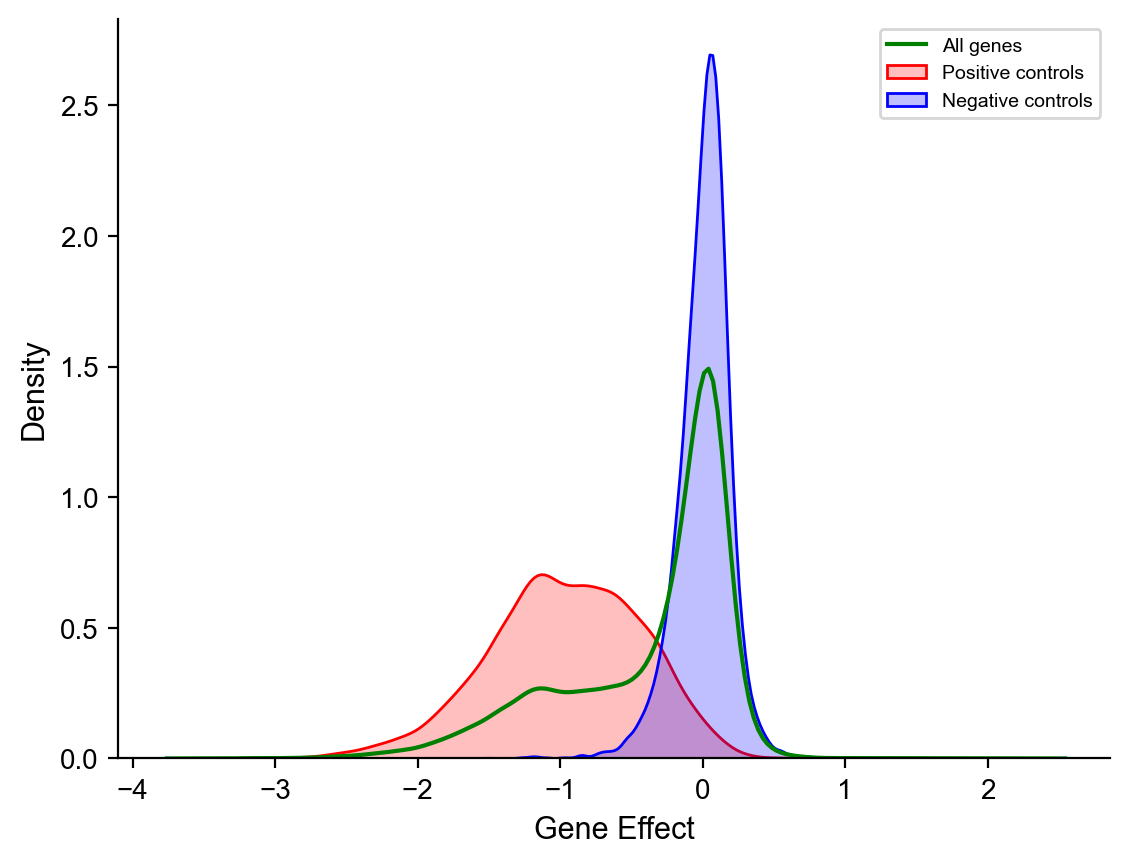

In [62]:
sns.kdeplot(np.ravel(corrected), label="All genes", color="green")
sns.kdeplot(np.ravel(corrected.reindex(columns=common_essentials)), label="Positive controls", color="red", fill=True)
sns.kdeplot(np.ravel(corrected.reindex(columns=nonessentials)), label="Negative controls", color="blue", fill=True)
plt.legend()
plt.xlabel("Gene Effect")

On the other hand, the power of the empirical p-values will be strictly limited by the number of negative controls. In fact, the minimum possible _p_ that can be achieved is 1 / len(negative_controls). This is likely to be an issue in a subgenome library. Below, we see the effect of this cap on significance:

Text(0, 0.5, '-Log10 P')

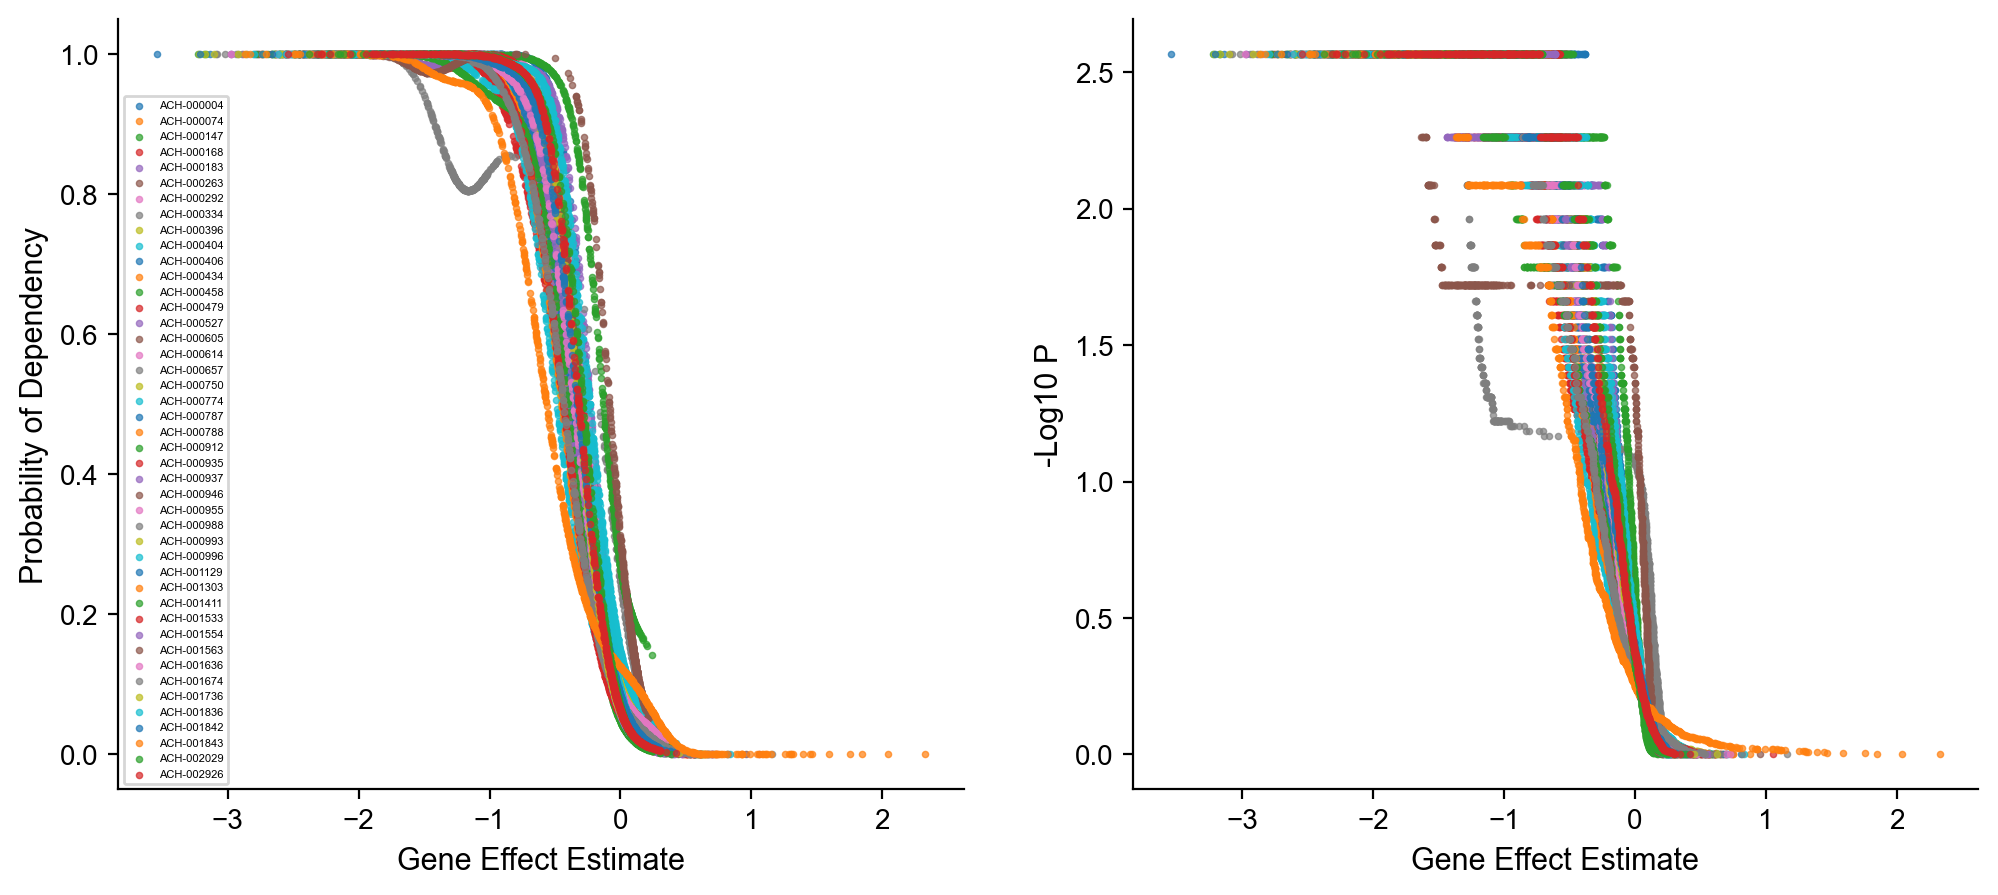

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axes[0])
for ind in probabilities.index:
    plt.scatter(corrected.loc[ind], probabilities.loc[ind], s=5, alpha=.7, linewidth=.5, label=ind)
plt.legend(fontsize=4, loc="lower left")
plt.xlabel("Gene Effect Estimate")
plt.ylabel("Probability of Dependency")

plt.sca(axes[1])
for ind in pvalues.index:
    plt.scatter(corrected.loc[ind], -np.log10(pvalues.loc[ind]), s=5, alpha=.7, linewidth=.5, label=ind)
plt.xlabel("Gene Effect Estimate")
plt.ylabel("-Log10 P")

We can make a roughly head-to-head comparison of discoveries from the two methods by estimating a false discovery rate using each. Using p-values for many hypotheses, false discovery is typically controlled with the Benjamini-Hochberg procedure. This is a frequentist FDR. In contrast, using probabilities of dependency, we can directly estimate the Bayesian FDR: the number of true discoveries below a threshold is just the sum of the probabilities of dependency. See https://arxiv.org/pdf/1803.05284.pdf for a discussion of frequentist and Bayesian false discovery.

In [64]:
from chronos.hit_calling import get_fdr_from_probabilities, get_fdr_from_pvalues
fdr_from_probabilities = get_fdr_from_probabilities(probabilities)
fdr_from_pvalues = get_fdr_from_pvalues(pvalues)

We'll do a quick, nonrigorous calibration check, considering only the control sets:

In [65]:
def calibration_check(fdr, positive_controls, negative_controls):
    controls_only = fdr\
    .reindex(columns=list(positive_controls) + list(negative_controls))\
    .dropna(axis=1)

    is_essential = pd.DataFrame(
        np.repeat(
            controls_only.columns.isin(positive_controls).reshape(1, -1), 
            len(controls_only), axis=0
        ),
       index=controls_only.index,
        columns=controls_only.columns
    )
    
    calibration = pd.DataFrame({
        "FDR": np.ravel(controls_only),
        "IsTrue": np.ravel(is_essential)
    }).sort_values("FDR")
    calibration["ProportionFalse"] = np.cumsum(~calibration.IsTrue) / np.arange(1, len(calibration)+1)
    
    return calibration

In [66]:
calibration_probabilities = calibration_check(fdr_from_probabilities, common_essentials, nonessentials)
calibration_pvalues = calibration_check(fdr_from_pvalues, common_essentials, nonessentials)

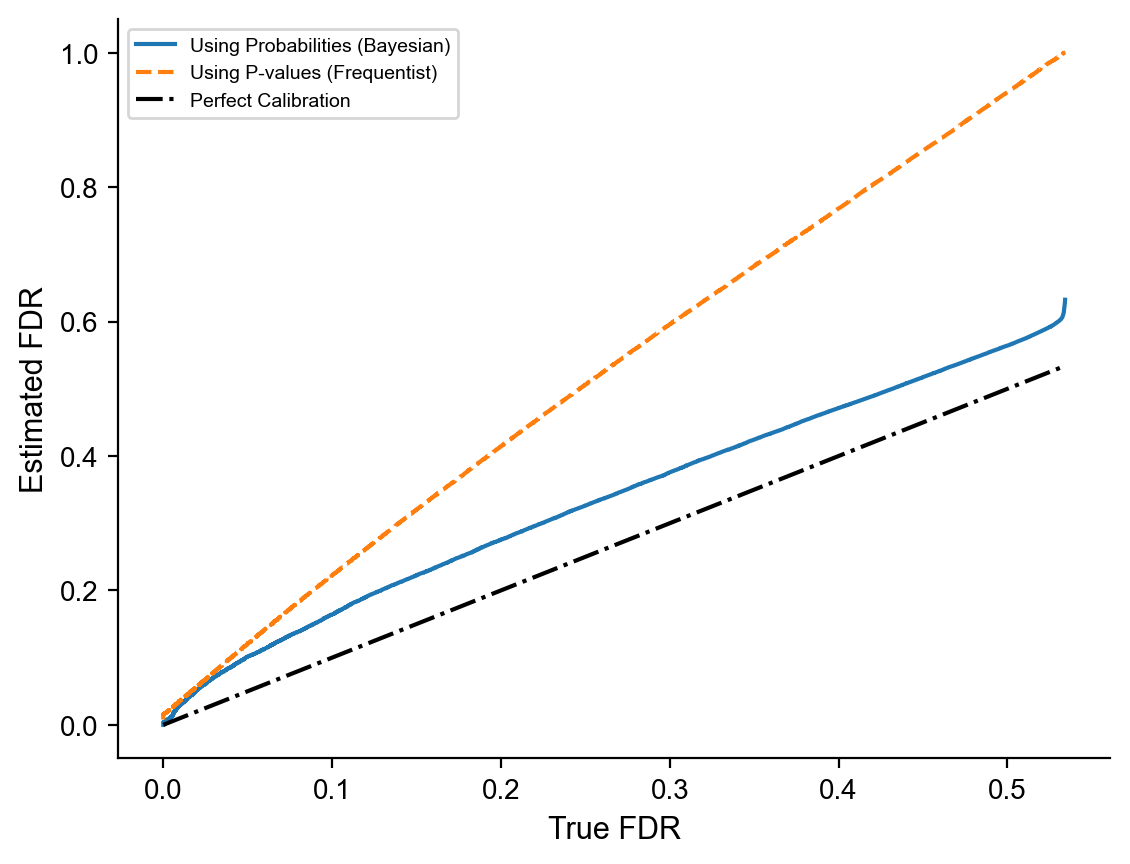

In [67]:
plt.plot(
    calibration_probabilities["ProportionFalse"],
    calibration_probabilities["FDR"],
    label="Using Probabilities (Bayesian)"
)

plt.plot(
    calibration_pvalues["ProportionFalse"],
    calibration_pvalues["FDR"],
    '--', 
    label="Using P-values (Frequentist)"
)

max_fdr = calibration_probabilities.ProportionFalse.max()
plt.plot([0, max_fdr], [0, max_fdr], '-.', color="black", label="Perfect Calibration")

plt.ylabel("Estimated FDR")
plt.xlabel("True FDR")
plt.legend()

We can see that both estimates of FDR are conservative, which is surely preferable to being optimistic. This may be partly due to the presence of the noncontrol genes in the full data, which have a lower proportion of true dependencies than the controls and affect the FDR estimates in the controls. The probability based method has an unfair advantage as it as seen the same set of positive controls as well as the negative controls. To be truly rigorous we would need to split the controls used in training and in evaluating calibration, and run Chronos without any non-control genes. 

Note that the BH estimates reach 1, while probability-based estimates saturate below 1. This is because the BH procedure assumes the proportion of true discoveries is approximately 0 over the whole dataset:

In [68]:
fdr_from_pvalues.max().max(), fdr_from_pvalues.max(axis=1).mean()

(1.0, 1.0)

In [69]:
fdr_from_probabilities.max(axis=1).max(), fdr_from_probabilities.max(axis=1).mean()

(0.6330216534307214, 0.5951358104162263)

If an estimated FDR is correct, 1- the maximum FDR for a cell line should be equal to the fraction of true dependencies in that cell line. The lowest probability-based estimate of 0.38 is close to the proportion of common essential genes in the dataset (0.36), illustrating the greater power of the FDRs computed this way. When we compute FDRs from p-values using the Benjamini-Hochberg procedure, we are estimating adjusted p-values to _control_ false discovery rather than the true FDR, and the adjusted p-values reach 1.

We should also note that having a large number of true dependencies our test library improves the apparent performance of the frequentist method, because it allows values to remain significant after the BH procedure. In a setting with few true dependencies, the frequentist method may become severely underpowered.

Summing up: using `get_probability_dependent` is more powerful, and especially so in the case of subgenome libraries with limited negative control sets and a modest proportion of true hits. However, it requires correctly specifying the positive control distribution by identifying _representative_ positive control genes independently from your screening data (ideally, independent of any CRISPR data). 

## Comparing a Screen in Two Conditions

### Data Format for Comparing Conditions

A common use case for comparing screens is the anchor screen, in which the same model is screened in two different conditions. In [DeWeirdt et al.](https://doi.org/10.1038%2Fs41467-020-14620-6) (2020), the Meljuso, OVCAR8, and A375 cell lines were screened using either small molecule inhibitors or S. Aureus knockouts of BCL2L1, MCL1, and PARP/PARP1 in combination with the Brunello genome-wide library. A subset of their screens with the BCL2L1 inhibitor A-1331852 is loaded below.

In [70]:
deweird_readcounts = chronos.read_hdf5("Data/SampleData/DeWeirdtReadcounts.hdf5")

deweirdt_condition_map = pd.read_csv("Data/SampleData/DeWeirdtConditionMap.csv")

deweirdt_guide_map = pd.read_csv("Data/SampleData/DeWeirdtGuideMap.csv")

deweirdt_negative_controls = deweirdt_guide_map.sgrna[
    deweirdt_guide_map.gene.isin([s.split(' ')[0] for s in nonessentials])
]

The readcounts and guide maps are formatted just like the Avana data above. The condition map is very similar to a sequence map, but requires two additional columns: `"replicate"` and `"condition"`. __Different replicates should be biologically independent__, ideally independently library-transfected cell populations. Different sequences of the same replicate should be assigned the same replicate name.

In [71]:
deweirdt_condition_map

,sequence_ID,replicate,cell_line_name,days,pDNA_batch,condition
0,pDNA,pDNA,pDNA,21,batch1,pDNA
1,Meljuso,RepA,Meljuso,21,batch1,Control
2,Meljuso.1,RepB,Meljuso,21,batch1,Control
3,Meljuso.2,RepA,Meljuso,21,batch1,A-1331852
4,Meljuso.3,RepB,Meljuso,21,batch1,A-1331852
5,OVCAR8,RepA,OVCAR8,21,batch1,Control
6,OVCAR8.1,RepB,OVCAR8,21,batch1,Control
7,OVCAR8.2,RepA,OVCAR8,21,batch1,A-1331852
8,OVCAR8.3,RepB,OVCAR8,21,batch1,A-1331852


Any cell line with less than two unique replicates in each of the two conditions being compared will not be evaluated.

It is important when running the comparison to first normalize the readcounts and `nan_outgrowths`. Otherwise, outliers that occur in single replicates will produce excessive noise that will reduce statistical power.

In [72]:
deweirdt_normed = chronos.normalize_readcounts(deweird_readcounts, deweirdt_negative_controls, deweirdt_condition_map)

In [73]:
chronos.nan_outgrowths(deweirdt_normed, deweirdt_condition_map, deweirdt_guide_map, rpm_normalize=False)

calculating LFC
stacking and annotating LFC
finding group boundaries
removing cases with only one guide and replicate
finding maximal values
making mask
found 26 outgrowths, 4.5E-05 of the total
pivoting mask
aligning_mask


/Users/dempster/packages/chronos_public/chronos/model.py:478: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lfc_stack["Mask"].loc[bad_rows] = True
/Users/dempster/packages/chronos_public/chronos/model.py:478: SettingWithCopyWarning: 
A value

NaNing


### Training with Conditions Distinguished

To understand how `ChronosComparison` works, it helps to first manually create a model with conditions distinguished. First, we create a sequence map that distinguishes conditions. We'll compare "Control" and "A-1331852". The function `create_condition_map` creates the map, while the function `filter_sequence_map_by_condition` restricts the sequences considered to those matching one of the designated conditions and to cell lines with at least two unique replicates in each batch. It also will trim the number of replicates considered so that there is an even and equal number in each condition for each the cell line.

In [74]:
from chronos.hit_calling import filter_sequence_map_by_condition, create_condition_sequence_map

condition_pair = ("Control", "A-1331852")
distinguished_map = create_condition_sequence_map(
    filter_sequence_map_by_condition(deweirdt_condition_map, condition_pair),
    condition_pair
)
    

In [75]:
distinguished_map

,sequence_ID,replicate,cell_line_name,days,pDNA_batch,condition,true_cell_line_name
0,pDNA,pDNA,pDNA,21,batch1,pDNA,pDNA
1,Meljuso,RepA,Meljuso__in__Control,21,batch1,Control,Meljuso
2,Meljuso.1,RepB,Meljuso__in__Control,21,batch1,Control,Meljuso
3,Meljuso.2,RepA,Meljuso__in__A-1331852,21,batch1,A-1331852,Meljuso
4,Meljuso.3,RepB,Meljuso__in__A-1331852,21,batch1,A-1331852,Meljuso
5,OVCAR8,RepA,OVCAR8__in__Control,21,batch1,Control,OVCAR8
6,OVCAR8.1,RepB,OVCAR8__in__Control,21,batch1,Control,OVCAR8
7,OVCAR8.2,RepA,OVCAR8__in__A-1331852,21,batch1,A-1331852,OVCAR8
8,OVCAR8.3,RepB,OVCAR8__in__A-1331852,21,batch1,A-1331852,OVCAR8


Notice that the `"cell_line_name"` column has been overwritten in the format "<cell_line>__in__<condition>". When we train Chronos, we'll get an individual assessment of each gene's effect in each cell line in each condition. The new column `"true_cell_line_name"` exists for convenience.

Running Chronos works just like before:

In [76]:
distinguished_model = chronos.Chronos(
    readcounts={"brunello": deweird_readcounts},
    sequence_map={"brunello": distinguished_map},
    guide_gene_map={"brunello": deweirdt_guide_map},
    negative_control_sgrnas={"brunello": deweirdt_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 71848 unique guides and 18238 unique genes in brunello
found 71848 unique guides and 18238 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 8 unique sequences (excluding pDNA), 8 unique replicates, and 4 unique cell lines in brunello
found 8 unique late time points and 4 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for brunello
Creating excess variance tensors
	Created excess variance tensor for brunello with shape [8, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [8, 1] for brunello

building late observed timepoints


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 1 (batch=Index(['batch1'], dtype='object')) and 1 (batch=Index(['batch1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


	built normalized timepoints for brunello with shape (8, 71848) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (1, 71848) for brunello
building guide efficacy
built guide efficacy: shape [1, 71849]
building growth rate
built growth rate: shape {'brunello': [8, 1]}

building replicate efficacy
built replicate efficacy: shapes {'brunello': [8, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 4 cell lines by 18238 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'brunello': [8, 18238]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'brunello': [8, 18238]}

building combined efficacy
built combined efficacy, shape {'brunello': [8, 71848]}
built expanded combined efficacy, shapes {'brunello': [8, 71848]}

building growth estimates of edited cells and overall estimates of fold change in guide abundan

2024-08-12 11:52:25.881347: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_15/brunello/Assign' id:44460 op device:{requested: '', assigned: ''} def:{{{node excess_variance_15/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_15/brunello, excess_variance_15/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph


2024-08-12 11:52:27.483331: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_15/library_effect/brunello/Assign' id:44574 op device:{requested: '', assigned: ''} def:{{{node GE_15/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_15/library_effect/brunello, GE_15/library_effect/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 brunello
{'brunello': replicate_ID
Meljuso__in__A-1331852__IN__A-1331852_RepA_batch1    0.822697
Meljuso__in__A-1331852__IN__A-1331852_RepB_batch1    0.802493
Meljuso__in__Control__IN__Control_RepA_batch1        0.809282
Meljuso__in__Control__IN__Control_RepB_batch1        0.793646
OVCAR8__in__A-1331852__IN__A-1331852_RepA_batch1     0.618191
OVCAR8__in__A-1331852__IN__A-1331852_RepB_batch1     0.604117
OVCAR8__in__Control__IN__Control_RepA_batch1         0.602468
OVCAR8__in__Control__IN__Control_RepB_batch1         0.592334
dtype: float64}


/Users/dempster/packages/chronos_public/chronos/model.py:2005: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	brunello _gene_effect
	brunello _selected_efficacies
	brunello_predicted_readcounts_unscaled
	brunello _predicted_readcounts
	brunello _normalized_readcounts
	brunello _cost_presum
sess run
	brunello _cost
	brunello _full_costs
ready to train


In [77]:
distinguished_model.train()

NB2 cost 0.3991733014150046
Full cost 0.41344486750531684
relative_growth_rate
	brunello max 1.024, min 0.96159
mean guide efficacy 0.9992065009154941
t0_offset SD: [('brunello', 6.766742800234974e-05)]

gene mean -0.06692586391821059
SD of gene means 0.2172180554985622
Mean of gene SDs 0.08560298631533862



51 epochs trained, time taken 0:00:20, projected remaining 0:01:38
NB2 cost 0.20262120758504967
Full cost 0.2348283792390444
relative_growth_rate
	brunello max 1.172, min 0.84158
mean guide efficacy 0.9210064144452821
t0_offset SD: [('brunello', 0.14898236363834205)]

gene mean 0.06301294471579773
SD of gene means 0.3546767420653138
Mean of gene SDs 0.12551738216296005



101 epochs trained, time taken 0:00:39, projected remaining 0:01:18
NB2 cost 0.1788675875315961
Full cost 0.20388359465134792
relative_growth_rate
	brunello max 1.123, min 0.87014
mean guide efficacy 0.8211833725759042
t0_offset SD: [('brunello', 0.1441963971609431)]

gene mean 0.000939796574060863
SD of gene mea

MCL1 and BCL2L1 are a well-established synthetic lethal pair in cancer. Below, we see a difference of about 1.5 between the gene effects of MCL1 in the control condition and in the BCL2L1 inhibitor A-1331852. 

In [78]:
distinguished_model.gene_effect['MCL1']

cell_line_name
Meljuso__in__A-1331852    0.062499
Meljuso__in__Control     -1.630182
OVCAR8__in__A-1331852     0.031462
OVCAR8__in__Control      -1.364929
Name: MCL1, dtype: float64

But are these differences significant?

### Running the Comparator

To test for significance, we first create a `hit_calling.ConditionComparison` instance. The input syntax is almost exactly the same as a `Chronos` model instance, except we replace the `sequence_map` argument with a `condition_map`.

In [79]:
from chronos.hit_calling import ConditionComparison
comparator = ConditionComparison(
    readcounts={"brunello": deweird_readcounts},
    condition_map={"brunello": deweirdt_condition_map},
    guide_gene_map={"brunello": deweirdt_guide_map},
    negative_control_sgrnas={"brunello": deweirdt_negative_controls},
)

To identify significant differences, `ConditionComparison` will first train a distinguished model, as above, then permute the condition labels so that each condition label has an equal number of replicates from each of the real conditions and train models on the permutations. These models have no biological difference between conditions, and can be used to form the null distribution. Permutations that have every condition flipped from an existing permutation are discarded. An example of a permuted map is shown below.

In [80]:
from chronos.hit_calling import create_permuted_sequence_maps

create_permuted_sequence_maps(deweirdt_condition_map, condition_pair)[0]

,cell_line_name,condition,replicate_ID,pDNA_batch,true_condition,sequence_ID,replicate,days,true_cell_line_name
0,Meljuso__in__A-1331852,A-1331852,Meljuso__IN__A-1331852_RepA_batch1,batch1,A-1331852,Meljuso.2,RepA,21,Meljuso
1,Meljuso__in__Control,Control,Meljuso__IN__A-1331852_RepB_batch1,batch1,A-1331852,Meljuso.3,RepB,21,Meljuso
2,Meljuso__in__A-1331852,A-1331852,Meljuso__IN__Control_RepA_batch1,batch1,Control,Meljuso,RepA,21,Meljuso
3,Meljuso__in__Control,Control,Meljuso__IN__Control_RepB_batch1,batch1,Control,Meljuso.1,RepB,21,Meljuso
4,OVCAR8__in__A-1331852,A-1331852,OVCAR8__IN__A-1331852_RepA_batch1,batch1,A-1331852,OVCAR8.2,RepA,21,OVCAR8
5,OVCAR8__in__Control,Control,OVCAR8__IN__A-1331852_RepB_batch1,batch1,A-1331852,OVCAR8.3,RepB,21,OVCAR8
6,OVCAR8__in__A-1331852,A-1331852,OVCAR8__IN__Control_RepA_batch1,batch1,Control,OVCAR8,RepA,21,OVCAR8
7,OVCAR8__in__Control,Control,OVCAR8__IN__Control_RepB_batch1,batch1,Control,OVCAR8.1,RepB,21,OVCAR8
8,pDNA,pDNA,pDNA__IN__pDNA_pDNA_batch1,batch1,pDNA,pDNA,pDNA,21,pDNA


The number of permutations limits the minimum p-value that can be calculated. Due to the requirement that we only consider permutations that have equal numbers of replicates from each condition, the number of permutations actually generated is as follows:

- Less than 2 replicates for any condition for a cell line: 0 permutations, that line is discarded
- 2-3 replicates for any condition of any cell line: 2 permutations
- At least 4 replicates for all conditions for all cell lines: 18 permutations
- At least 6 replicates for all conditions for all cell lines: 200 permutations
  
For obvious reasons, we don't recommend including more than 4 replicates per condition unless your library is very small.

Now, to compare the conditions. Note that with three models to train, this may take about 10 minutes.

In [81]:
comparison_statistics = comparator.compare_conditions(("A-1331852", "Control"))

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:605: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna")["gene"], axis=1)\


training model without conditions distinguished


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 1 (batch=Index(['batch1'], dtype='object')) and 1 (batch=Index(['batch1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-08-12 11:54:30.792003: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_16/brunello/Assign' id:47485 op device:{requested: '', assigned: ''} def:{{{node excess_variance_16/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_16/brunello, excess_variance_16/brunello/Initializer/initial_val

{'brunello': replicate_ID
Meljuso__IN__A-1331852_RepA_batch1    0.822697
Meljuso__IN__A-1331852_RepB_batch1    0.802493
Meljuso__IN__Control_RepA_batch1      0.809282
Meljuso__IN__Control_RepB_batch1      0.793646
OVCAR8__IN__A-1331852_RepA_batch1     0.618191
OVCAR8__IN__A-1331852_RepB_batch1     0.604117
OVCAR8__IN__Control_RepA_batch1       0.602468
OVCAR8__IN__Control_RepB_batch1       0.592334
dtype: float64}


/Users/dempster/packages/chronos_public/chronos/hit_calling.py:61: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(model.guide_gene_map[key].set_index("sgrna")["gene"], axis=1).sum()


training model with conditions distinguished


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 1 (batch=Index(['batch1'], dtype='object')) and 1 (batch=Index(['batch1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-08-12 11:56:29.248230: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_17/brunello/Assign' id:50460 op device:{requested: '', assigned: ''} def:{{{node excess_variance_17/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_17/brunello, excess_variance_17/brunello/Initializer/initial_val

{'brunello': replicate_ID
Meljuso__IN__A-1331852_RepA_batch1    0.822697
Meljuso__IN__A-1331852_RepB_batch1    0.802493
Meljuso__IN__Control_RepA_batch1      0.809282
Meljuso__IN__Control_RepB_batch1      0.793646
OVCAR8__IN__A-1331852_RepA_batch1     0.618191
OVCAR8__IN__A-1331852_RepB_batch1     0.604117
OVCAR8__IN__Control_RepA_batch1       0.602468
OVCAR8__IN__Control_RepB_batch1       0.592334
dtype: float64}


/Users/dempster/packages/chronos_public/chronos/hit_calling.py:61: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(model.guide_gene_map[key].set_index("sgrna")["gene"], axis=1).sum()


training models with permuted conditions
	random iteration 0


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 1 (batch=Index(['batch1'], dtype='object')) and 1 (batch=Index(['batch1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-08-12 11:58:34.242294: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_18/brunello/Assign' id:53413 op device:{requested: '', assigned: ''} def:{{{node excess_variance_18/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_18/brunello, excess_variance_18/brunello/Initializer/initial_val

{'brunello': replicate_ID
Meljuso__IN__A-1331852_RepA_batch1    0.822697
Meljuso__IN__A-1331852_RepB_batch1    0.802493
Meljuso__IN__Control_RepA_batch1      0.809282
Meljuso__IN__Control_RepB_batch1      0.793646
OVCAR8__IN__A-1331852_RepA_batch1     0.618191
OVCAR8__IN__A-1331852_RepB_batch1     0.604117
OVCAR8__IN__Control_RepA_batch1       0.602468
OVCAR8__IN__Control_RepB_batch1       0.592334
dtype: float64}


/Users/dempster/packages/chronos_public/chronos/hit_calling.py:61: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(model.guide_gene_map[key].set_index("sgrna")["gene"], axis=1).sum()


	random iteration 1


/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 1 (batch=Index(['batch1'], dtype='object')) and 1 (batch=Index(['batch1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1351: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
2024-08-12 12:00:38.554377: W tensorflow/c/c_api.cc:304] Operation '{name:'excess_variance_19/brunello/Assign' id:56366 op device:{requested: '', assigned: ''} def:{{{node excess_variance_19/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_19/brunello, excess_variance_19/brunello/Initializer/initial_val

{'brunello': replicate_ID
Meljuso__IN__A-1331852_RepA_batch1    0.822697
Meljuso__IN__A-1331852_RepB_batch1    0.802493
Meljuso__IN__Control_RepA_batch1      0.809282
Meljuso__IN__Control_RepB_batch1      0.793646
OVCAR8__IN__A-1331852_RepA_batch1     0.618191
OVCAR8__IN__A-1331852_RepB_batch1     0.604117
OVCAR8__IN__Control_RepA_batch1       0.602468
OVCAR8__IN__Control_RepB_batch1       0.592334
dtype: float64}
calculating empirical significance


/Users/dempster/packages/chronos_public/chronos/hit_calling.py:61: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(model.guide_gene_map[key].set_index("sgrna")["gene"], axis=1).sum()


Below, we can see the most significant differences. The expected hit MCL1 was found in both screens, while BAX and BCL2 were found in Meljuso. [MARCH5, UBE2J, and UBE2K are also expected findings](https://doi.org/10.1038/s41375-024-02178-x). Meljuso appears to be a cleaner screen with overall more significant hits, but at least one difference between it and OVCAR8 stems from different underlying biology: OVCAR8 is TP53 null. 

In [82]:
comparison_statistics.sort_values(["gene"]).loc[lambda x: x.likelihood_fdr < .05]

,cell_line_name,gene,gene_effect_in_A-1331852,gene_effect_in_Control,gene_effect_difference,likelihood,likelihood_undistinguished,likelihood_permutation_0,likelihood_permutation_1,likelihood_pval,readcount_bin,likelihood_fdr
1384,Meljuso,BAX,0.130719,0.918304,0.787585,-1233.401745,-1263.815041,-1262.944137,-1263.929586,1.283730e-07,"(815.0, 12384.75]",5.699679e-04
1423,Meljuso,BCL2,0.342512,-0.434956,-0.777468,-885.147364,-903.349547,-898.651762,-899.782072,6.817695e-06,"(815.0, 12384.75]",2.072352e-02
8909,Meljuso,MARCH5,0.245070,-1.991027,-2.236096,-942.066615,-1026.638312,-1024.901996,-1023.264251,7.258860e-12,"(815.0, 12384.75]",1.323871e-07
27231,OVCAR8,MCL1,0.055763,-1.361082,-1.416845,-1144.716078,-1163.455213,-1158.815886,-1163.725223,2.719582e-06,"(815.0, 12384.75]",2.479987e-02
8993,Meljuso,MCL1,0.087336,-1.640505,-1.727841,-891.647845,-943.405137,-943.561657,-942.344296,1.085449e-09,"(815.0, 12384.75]",9.898208e-06
11870,Meljuso,PMAIP1,0.115910,0.922978,0.807067,-1061.362746,-1091.065656,-1090.926042,-1090.132838,1.562583e-07,"(815.0, 12384.75]",5.699679e-04
16306,Meljuso,TP53,1.263288,1.823763,0.560476,-1365.341612,-1381.278187,-1368.281876,-1378.998878,1.723661e-05,"(815.0, 12384.75]",4.490876e-02
16802,Meljuso,UBE2J2,0.191474,-1.200998,-1.392472,-905.637449,-950.045090,-948.091174,-946.763590,4.599244e-09,"(815.0, 12384.75]",2.796033e-05
35041,OVCAR8,UBE2K,0.045088,-1.716752,-1.761839,-1112.928860,-1140.585014,-1139.398505,-1140.222741,1.887640e-07,"(815.0, 12384.75]",3.442679e-03


### Other notes

If you want to compare two different screens in the same condition, you can create a condition map in which the two cell lines are assigned the same `"cell_line_name"` but a different `"condition"`. However, bear in mind that your real differences are likely to be confounded with batch effects. You can assess the degree of this problem by checking for false discoveries among negative controls or unexpressed genes.

You may also find that your hits are dominated by common essentials. This can happen because the two conditions have different screen quality. In particular, if one condition is mildly or moderately growth-inhibiting, this can lead to less apparent common essential dropout (because all other cells are also dropping out) vs the other condition and make these genes appear systematically different in gene effect. This can be addressed by both increasing the `gene_effect_hierarchical` regularization in `ChronosCompare` (see `chronos.Chronos` for a description), and potentially also adding new bins to `gene_readcount_total_bin_quantiles` (default": `[0.05]`) in `compare_conditions` (see `chronos.hit_calling.ConditionComparison.compare_conditions`.)

## Running with multiple libraries

We can add Sanger's [Project Score](https://www.nature.com/articles/s41586-019-1103-9) data (screened with the KY library) and run Chronos jointly on it and the Avana data. 

In [83]:
ky_guide_map = pd.read_csv("./Data/SampleData/KYGuideMap.csv")
ky_sequence_map = pd.read_csv("./Data/SampleData/KYSequenceMap.csv")
ky_readcounts = chronos.read_hdf5("./Data/SampleData/KYReadcounts.hdf5")

In [84]:
ky_positive_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(common_essentials)]
ky_negative_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(nonessentials)]

Note how the call signature of Chronos with multiple libraries is constructed:

In [93]:
ky_readcounts.isnull().sum(axis=1).sort_values()

pDNA_batch_KY-2        0
pDNA_batch_KY-1        0
RCCFG2_C908R3_KY-1     1
RCCFG2_C908R2_KY-1     1
RCCFG2_C908R1_KY-1     1
                      ..
HEC1_c907R3_KY-1      24
HEC1_c907R2_KY-1      24
SNU81_c903R1_KY-2     37
SNU81_c903R2_KY-2     37
SNU81_c903R3_KY-2     37
Length: 65, dtype: int64

In [100]:
model2 = chronos.Chronos(
    sequence_map={"avana": sequence_map, 'ky': ky_sequence_map},
    guide_gene_map={"avana": guide_map, 'ky': ky_guide_map},
    readcounts={"avana": readcounts, 'ky': ky_readcounts},
    negative_control_sgrnas={"avana": negative_controls, "ky": ky_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 4084 unique guides and 833 unique genes in ky
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 63 unique sequences (excluding pDNA), 63 unique replicates, and 23 unique cell lines in ky
found 155 unique late time points and 58 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
	Estimating excess variance (alpha) for ky
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
	Created excess variance tensor for

/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) and 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 4 (batch=Index(['KY-1'], dtype='object')) and 39 (batch=Index(['KY-2'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1355: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.i

	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)
	built normalized timepoints for ky with shape (63, 4084) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 4084) for avana
made t0 batch with shape (2, 4084) for ky
building guide efficacy
built guide efficacy: shape [1, 7559]
building growth rate
built growth rate: shape {'avana': [92, 1], 'ky': [63, 1]}

building replicate efficacy
built replicate efficacy: shapes {'avana': [92, 1], 'ky': [63, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 58 cell lines by 887 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 887], 'ky': [63, 887]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [92, 887], 'ky': [63, 887]}

building combined efficacy
built combined efficacy, shape {'avana': [92, 3474], 

2024-08-12 14:51:36.883621: W tensorflow/c/c_api.cc:304] Operation '{name:'inferred_t0_24/base_avana/Assign' id:78625 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_24/base_avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_24/base_avana, inferred_t0_24/base_avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer


Exception ignored in: <function Chronos.__del__ at 0x444b6f7e0>
Traceback (most recent call last):
  File "/Users/dempster/packages/chronos_public/chronos/model.py", line 2490, in __del__
    self.sess.close()
    ^^^^^^^^^
AttributeError: 'Chronos' object has no attribute 'sess'


initializing rest of graph


2024-08-12 14:51:40.710236: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_24/library_effect/ky/Assign' id:78782 op device:{requested: '', assigned: ''} def:{{{node GE_24/library_effect/ky/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_24/library_effect/ky, GE_24/library_effect/ky/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 avana
	 ky
{'avana': replicate_ID
ACH-000004_Avana-3_HEL-311Cas9_RepA_p4_Avana-3      0.848895
ACH-000004_Avana-3_HEL-311Cas9_RepB_p4_Avana-3      0.839082
ACH-000074_Avana-3_KU812-311cas9-RepA-p6_Avana-3    0.800177
ACH-000074_Avana-3_KU812-311cas9-RepB-p6_Avana-3    0.737671
ACH-000147_Avana-4_T47D-311Cas9-RepA-p6_Avana-4     0.900404
                                                      ...   
ACH-001843_Avana-3_ICC3-311cas9_RepB_p6_Avana-3     0.979425
ACH-002029_Avana-4_SAS-311cas9-RepA-p6_Avana-4      0.901975
ACH-002029_Avana-4_SAS-311cas9-RepB-p6_Avana-4      0.912121
ACH-002926_Avana-4_UPMD1-311cas9-RepA-p6_Avana-4    0.690049
ACH-002926_Avana-4_UPMD1-311cas9-RepB-p6_Avana-4    0.716305
Length: 92, dtype: float64, 'ky': replicate_ID
ACH-000147_KY-2_T47d_c903R2_KY-2      0.936306
ACH-000147_KY-2_T47d_c903R3_KY-2      0.937123
ACH-000149_KY-1_SKNSH_c906R1_KY-1     0.989990
ACH-000149_KY-1_SKNSH_c906R2_KY-1     0.986197
ACH-000

In [101]:
model2.train(301)

NB2 cost 0.727986713699823
Full cost 0.880178839791503
relative_growth_rate
	avana max 1.039, min 0.96435
	ky max 1.040, min 0.94475
mean guide efficacy 0.9991671677457519
t0_offset SD: [('avana', 7.057347774681473e-05), ('ky', 7.592626472748726e-05)]

gene mean -0.2598303274712771
SD of gene means 0.430249704359308
Mean of gene SDs 0.3511754874721306



51 epochs trained, time taken 0:00:04, projected remaining 0:00:19
NB2 cost 0.339027300911562
Full cost 0.42117272450658605
relative_growth_rate
	avana max 1.128, min 0.38771
	ky max 1.388, min 0.45419
mean guide efficacy 0.8985810191789981
t0_offset SD: [('avana', 0.14477393812257477), ('ky', 0.134973802096055)]

gene mean -0.1551578497450504
SD of gene means 0.44956692002385185
Mean of gene SDs 0.2771686519260135



101 epochs trained, time taken 0:00:06, projected remaining 0:00:13
NB2 cost 0.2654941121115779
Full cost 0.2928517407561188
relative_growth_rate
	avana max 1.618, min 0.20911
	ky max 1.687, min 0.56840
mean guide efficac

Note that the gene effect now has NAs. These are cases where a cell line was only screened in one library and that library had no guides for that gene.

Chronos infers library batch effects. Note that these are only inferred for genes present in all libraries

## Running your screen with pretrained DepMap parameters

If you conducted a screen in one of the DepMap integrated libraries (currently Avana, KY, or Humagne-CD), you can load parameters from the trained DepMap model and use them to process your specific screen. This gives you many of the benefits of coprocessing your screen with the complete DepMap dataset without the computational expense. 

The following command fetches the 23Q4 public dataset from Figshare and stores it in the Chronos package directory under Data/DepMapParameters

In [ ]:
chronos.fetch_parameters()

First, we create a model with the data we want to train as before, but with two important details:
- we pass the argument `pretrained=True` when we initialize
- the library batch names must match the DepMap library batch names, as that's what we're using for the pretrained model

In [114]:
model2_pretrained = chronos.Chronos(
    sequence_map={"Achilles-Avana-2D": sequence_map, 'Achilles-KY-2D': ky_sequence_map},
    guide_gene_map={"Achilles-Avana-2D": guide_map, 'Achilles-KY-2D': ky_guide_map},
    readcounts={"Achilles-Avana-2D": readcounts, 'Achilles-KY-2D': ky_readcounts},
    negative_control_sgrnas={"Achilles-Avana-2D": negative_controls, "Achilles-KY-2D": ky_negative_controls},
    pretrained=True
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 4084 unique guides and 833 unique genes in ky
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 63 unique sequences (excluding pDNA), 63 unique replicates, and 23 unique cell lines in ky
found 155 unique late time points and 58 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
	Estimating excess variance (alpha) for ky
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
	Created excess variance tensor for

/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) and 0 (batch=Index(['Avana-2', 'Avana-3', 'Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:379: UserWarning: Between 4 (batch=Index(['KY-1'], dtype='object')) and 39 (batch=Index(['KY-2'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
  warn("Between %i (batch=%r) and %i (batch=%r) negative control sgRNAs were found to be \
/Users/dempster/packages/chronos_public/chronos/model.py:1355: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.i

	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)
	built normalized timepoints for ky with shape (63, 4084) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 4084) for avana
made t0 batch with shape (2, 4084) for ky
building guide efficacy
built guide efficacy: shape [1, 7559]
building growth rate
built growth rate: shape {'avana': [92, 1], 'ky': [63, 1]}

building replicate efficacy
built replicate efficacy: shapes {'avana': [92, 1], 'ky': [63, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 58 cell lines by 887 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 887], 'ky': [63, 887]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [92, 887], 'ky': [63, 887]}

building combined efficacy
built combined efficacy, shape {'avana': [92, 3474], 

2024-08-12 15:00:57.909538: W tensorflow/c/c_api.cc:304] Operation '{name:'inferred_t0_26/base_avana/Assign' id:88183 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_26/base_avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_26/base_avana, inferred_t0_26/base_avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph


2024-08-12 15:01:01.516231: W tensorflow/c/c_api.cc:304] Operation '{name:'GE_26/library_effect/ky/Assign' id:88333 op device:{requested: '', assigned: ''} def:{{{node GE_26/library_effect/ky/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_26/library_effect/ky, GE_26/library_effect/ky/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 avana
	 ky
	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
	ky _gene_effect
	ky _selected_efficacies
	ky_predicted_readcounts_unscaled
	ky _predicted_readcounts
	ky _normalized_readcounts
	ky _cost_presum
sess run
	ky _cost
	ky _full_costs
waiting for user to load model


Now we import the DepMap data from the directory into the model, and train:

In [117]:
model2_pretrained.import_model("./Data/DepMapParameters/")

Chronos model loaded
ready to train


In [118]:
model2_pretrained.train()

NB2 cost 0.571136085473464
Full cost 0.7255062831261139
relative_growth_rate
	avana max 1.038, min 0.94576
	ky max 1.051, min 0.95759
mean guide efficacy 0.8655593679402025
t0_offset SD: [('avana', 0.1379622445524905), ('ky', 0.10661651675174089)]

gene mean 0.0039106232387402075
SD of gene means 0.6559212833086104
Mean of gene SDs 0.34839098901300475



51 epochs trained, time taken 0:00:02, projected remaining 0:00:12
NB2 cost 0.3013120834645763
Full cost 0.36920390869939684
relative_growth_rate
	avana max 1.195, min 0.27550
	ky max 1.466, min 0.46438
mean guide efficacy 0.8655593679402025
t0_offset SD: [('avana', 0.1379622445524905), ('ky', 0.10661651675174089)]

gene mean -0.0031656744594167727
SD of gene means 0.6627671298598236
Mean of gene SDs 0.2771002118675345



101 epochs trained, time taken 0:00:03, projected remaining 0:00:06
NB2 cost 0.24987813278355323
Full cost 0.27709026685685634
relative_growth_rate
	avana max 1.902, min 0.05341
	ky max 1.812, min 0.50754
mean guide e